## Initialize VizDoom

In [ ]:
#necessary
!pip install vizdoom
!pip install opencv-python
!pip install pandas

In [ ]:
# import VizDoom for game env
from vizdoom import *
# Import random for action sampling
import random
# Import time for sleeping
import time
# import numpy for identity matrix
import numpy as np

from matplotlib import pyplot as plt

## Make it a Gym Env

In [ ]:
# Import environment base class from OpenAI Gym
from gymnasium import Env
# Import gym spaces
from gymnasium.spaces import Discrete, Box
# Import Opencv for greyscaling observations
import cv2

LEVEL = 'deadly_corridor'
DOOM_SKILL = 's1'

In [ ]:
# Create VizDoom OpenAI Gym Environment
class VizDoomGym(Env): 
    def __init__(self, render=False, config=f'VizDoom/scenarios/{LEVEL}_{DOOM_SKILL}.cfg'):
        """
        Function called when we start the env.
        """

        # Inherit from Env
        super().__init__()
        
        # Set up game
        self.game = DoomGame()
        self.game.load_config(config)
        

        # Whether we want to render the game 
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)

        # Start the game
        self.game.init()
        
        # Create action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8)
        self.action_space = Discrete(7)

        # Game variables: HEALTH DAMAGE_TAKEN DAMAGECOUNT SELECTED_WEAPON_AMMO 
        ## We want the change in these variable values, rather than the PiT values
        self.damage_taken = 0
        self.damagecount = 0
        self.ammo = 52

    
    def step(self, action):
        """
        How we take a step in the environment.
        """

        # Specify action and take step
        actions = np.identity(7, dtype=np.uint8)
        # Movement rewards encapsulates predefined reward in the environment config
        movement_reward = self.game.make_action(actions[action], 4) # get action using index -> left, right, shoot

        reward = 0
        # Get all the other stuff we need to return 
        if self.game.get_state():  # if nothing is
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)  # Apply Grayscale
            # ammo = self.game.get_state().game_variables[0] 

            # Reward shaping
            game_variables = self.game.get_state().game_variables # get current PiT game variables
            health, damage_taken, damagecount, ammo = game_variables # unpack

            # calculate change in damage_taken, hitcount, ammo
            damage_taken_delta = -damage_taken + self.damage_taken # disincentivizng us to take damage
            self.damage_taken = damage_taken
            damagecount_delta = damagecount - self.damagecount # increments by +1: incentivizing more hitcounts (1 hitcount = 1 reward)
            self.damagecount = damagecount
            ammo_delta = ammo - self.ammo # increments by -1: disincentiving us to take shots that miss
                                          # hitcount and ammo will cancel each other out
            self.ammo = ammo

            # Pack everything into reward function (tuned weights)
            reward = movement_reward + damage_taken_delta*10 + damagecount_delta*200 + ammo_delta*5
            
            info = ammo
        # If we dont have anything turned from game.get_state
        else:
            # Return a numpy zero array
            state = np.zeros(self.observation_space.shape)
            # Return info (game variables) as zero
            info = 0

        info = {"info":info}
        done = self.game.is_episode_finished()
        truncated = False  # Assuming it's not truncated, modify if applicable
        
        return state, reward, done, truncated, info

    
    def render(self):
        """
        Define how to render the game environment.
        """
        pass

    
    def reset(self, seed=None):
        """
        Function for defining what happens when we start a new game.
        """
        if seed is not None:
            self.game.set_seed(seed)
            
        self.game.new_episode()
        state = self.game.get_state().screen_buffer  # Apply Grayscale

        return self.grayscale(state), {}

    
    def grayscale(self, observation):
        """
        Function to grayscale the game frame and resize it.
        observation: gameframe
        """
        # Change colour channels 
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)

        # Reduce image pixel size for faster training
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize,(100, 160,1))
        return state

    def close(self):
        """
        Call to close down the game.
        """
        self.game.close()

    def run_model(self, observation):
        """
        Run the PyTorch model on the observation to select an action.

        Parameters:
            observation (np.ndarray): The observation from the environment.

        Returns:
            int: The action selected by the model.
        """
        # Preprocess the observation if necessary
        # For example, if your model expects a specific input shape
        
        # Convert observation to torch tensor
        observation = torch.tensor(observation, dtype=torch.float32)[0]
        
        # If necessary, move the observation to the correct device (e.g., GPU)
        # observation = observation.to(device)
        
        # Run the model to get action logits
        with torch.no_grad():
            action_logits = model(observation)  # Assuming batch size of 1
            
        # Select the action with the highest probability
        action = torch.argmax(action_logits).item()
        
        return action

## Custom PPO model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [37]:

class ActorCriticNetwork(nn.Module):
    def __init__(self, in_channels, n_output, gae_lambda):
        super(ActorCriticNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # Temporarily assume some output size after convolution
        # This should ideally be calculated based on input size
        self.feature_count = 64 * conv2d_size_out(conv2d_size_out(conv2d_size_out(100, 8, 4), 4, 2), 3, 1) * \
                        conv2d_size_out(conv2d_size_out(conv2d_size_out(160, 8, 4), 4, 2), 3, 1)

        self.fc = nn.Linear(self.feature_count, 512)
        self.actor = nn.Linear(512, n_output)
        self.critic = nn.Linear(512, 1)
        self.gae_lambda = gae_lambda 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.reshape(-1, self.feature_count)  # Use reshape instead of view
        x = F.relu(self.fc(x))
        action_probs = F.softmax(self.actor(x), dim=1)
        value = self.critic(x)
        return action_probs, value

## Implement helper functions

In [38]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    """
    Calculate the returns using the rewards and the next state's value estimate.
    """
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

def ppo_update(policy_net, optimizer, states, actions, log_probs_old, returns, advantages, clip_param=0.1):
    """
    Perform one update step of the PPO algorithm.
    """
    for _ in range(10):  # PPO epochs
        # Get the log probabilities and state values from the model
        log_probs, state_values = policy_net(states)
        # Select the log probabilities for the actions taken
        log_probs = log_probs.gather(1, actions.unsqueeze(-1)).squeeze(-1)
        # Calculate entropy to encourage exploration
        entropy = -(log_probs * torch.exp(log_probs)).sum(1, keepdim=True).mean()

        # Calculate the ratio (pi_theta / pi_theta_old) for the actions taken
        ratios = torch.exp(log_probs - log_probs_old)
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1.0 - clip_param, 1.0 + clip_param) * advantages
        policy_loss = -torch.min(surr1, surr2).mean()
        value_loss = F.smooth_l1_loss(state_values.squeeze(-1), returns)
        loss = policy_loss + 0.5 * value_loss - 0.01 * entropy

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


## Training loop

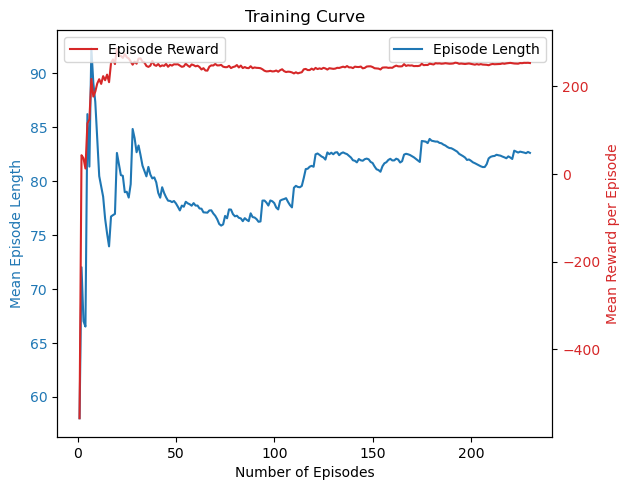

230
231
232


ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.

In [42]:
import os
import pandas as pd
from IPython.display import clear_output
def train(env, model, num_episodes, device, save_dir="./train/train_corridor", save_interval=5):
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    model.to(device)
    gamma = 0.95

    episode_lengths = []
    episode_rewards = []

    checkpoint_episode = []
    checkpoint_avg_rewards = []
    checkpoint_avg_lengths = []

    for episode in range(num_episodes):
        print(episode)
        state = env.reset()
        state_array = np.array(state[0])
        state = torch.from_numpy(state_array).float().unsqueeze(0).permute(0, 3, 1, 2).to(device)
        done = False
        total_reward = 0
        episode_length = 0

        while not done:
            policy_dist, value = model(state)
            action = policy_dist.multinomial(num_samples=1).detach()
            next_state, reward, done, _, _ = env.step(action.item())
            next_state = torch.from_numpy(next_state).float().unsqueeze(0).permute(0, 3, 1, 2).to(device)

            total_reward += reward
            episode_length += 1

            # Calculate and update loss here

            state = next_state

        episode_lengths.append(episode_length)
        episode_rewards.append(total_reward)

        # Save the model every save_interval episodes
        if (episode + 1) % save_interval == 0:
            print(f"Episode {episode + 1}: Completed. Total Reward: {total_reward}")
            
            # Ensure the directory exists before saving the model
            os.makedirs(save_dir, exist_ok=True)
            
            save_path = os.path.join(save_dir, f"model_episode_{episode + 1}.pt")
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at episode {episode + 1} to {save_path}")

            # Calculate running averages of episode length and reward
            avg_episode_lengths = [np.mean(episode_lengths[:i + 1]) for i in range(episode + 1)]
            avg_episode_rewards = [np.mean(episode_rewards[:i + 1]) for i in range(episode + 1)]

            # Save data in checkpoint
            checkpoint_episode.append(episode+1)
            checkpoint_avg_rewards.append(avg_episode_rewards[-1])
            checkpoint_avg_lengths.append(avg_episode_lengths[-1])
            
            # Clear previous output
            clear_output(wait=True)

            # Plotting
            fig, ax1 = plt.subplots()

            ax1.set_xlabel('Number of Episodes')
            ax1.set_ylabel('Mean Episode Length', color='tab:blue')
            ax1.plot(range(1, episode + 2), avg_episode_lengths, color='tab:blue',label='Episode Length')
            ax1.tick_params(axis='y', labelcolor='tab:blue')

            ax2 = ax1.twinx()
            ax2.set_ylabel('Mean Reward per Episode', color='tab:red')
            ax2.plot(range(1, episode + 2), avg_episode_rewards, color='tab:red',label='Episode Reward')
            ax2.tick_params(axis='y', labelcolor='tab:red')

            fig.tight_layout()
            ax1.legend(loc='upper right')
            ax2.legend(loc='upper left')
            plt.title('Training Curve')

            plt.show()

    return pd.DataFrame({
       "Episode": checkpoint_episode,
       "Mean Reward": checkpoint_avg_rewards,
       "Mean Episode Length": checkpoint_avg_lengths
    }) 

if __name__ == "__main__":
    env = VizDoomGym(render=True)
    in_channels = 1  # Assuming grayscale input
    n_actions = env.action_space.n
    gae_lambda = .9
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ActorCriticNetwork(in_channels, n_actions, gae_lambda)
    num_episodes = 10000
    training_data = train(env, model, num_episodes, device)

In [34]:
training_data

,Episode,Mean Reward,Mean Episode Length
